In [31]:
%run init_notebookspace.py

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\bayes_filter\data


# multi dimension filtering

gaussian

In [8]:
import numpy as np
import sympy as sp

import matplotlib.pyplot as plt

In [9]:
from scipy.stats import multivariate_normal

In [10]:
μ = np.array([.5, .8])
P = np.array([[8., 0.], 
              [0., 3.]])

mn = multivariate_normal(μ, P)
mn.pdf([.4, .3])

0.031142069767903083

generate data example

In [11]:
import math
import numpy as np
from numpy.random import randn
from filterpy.common import Q_discrete_white_noise

# generate random data
def compute_dog_data(z_var, process_var, count=1, dt=1.):
    "returns track, measurements 1D ndarrays"
    x, vel = 0., 1.
    z_std = math.sqrt(z_var) 
    p_std = math.sqrt(process_var)
    xs, zs = [], []
    for _ in range(count):
        v = vel + (randn() * p_std)
        x += v*dt        
        xs.append(x)
        zs.append(x + randn() * z_std)        
    return np.array(xs), np.array(zs)

Kalman Filter equations

$\bf{x}_{2x1}$ state space, $\bf \bar{x}$ is the $x_{t+1}$ prediction \
$\bf{F}$ state transition matrix: $x_t$  -> $x_{t+1}$ \
$\bf{u}$ steering directions fed to the object \
$\bf{B}$ steering directions transition matrix, translates into position \

$\bf{z}_{1x1}$ measurement \
$\bf{y}_{1x1}$ residual of prediction $\bf \bar{x}$ and measurement \
$\bf{H}_{2 x 1}$ transition matrix to translate velocity prediction back to position

$\bf{S}$ System uncertainty \
$\bf{K}$ Kalman gain, scales $x_{t+1}$ between measurement and prediction based on either's uncertainity

Prediction Step:

$$ \bf \bar{x} = Fx + Bu$$
$$ \bf \bar{P} = FPF^T + Q $$

measurment space: translate velocity back to position to calculate residual $y$
$$ \bf y = z - H\bar{x} $$
$$ \bf K = \bar{P} H^T S^{-1} \approx \frac{uncertainty_{pred}}{uncertainity_{measure}} H^T $$

Update:
$$ \bf x_{t+1} = \bar{x} + Ky $$
$$ \bf P_{t+1} = (I - KH) \bar{P} $$

Defining the state space

In [12]:
x = np.array([10., 4.5]) # state variable x, position x, y in a cordinate system
P = np.diag([500., 49.]) # cov matrix

system equation: we need to define a system euqation which we believe to describe the systems evolution
$$x_t = \dot{x} t + x_{t-1}$$
in this case Newtons law of motion, which in matrix forms turns into:

In [13]:
x1, dx1, x, dx, dt = sp.symbols(['x_{t+1}', '\dot{x}_{t+1}', 'x_t', '\dot{x}_t', '\Delta_t'])
X1 = sp.Matrix([x1, dx1]) # state t+1
A = sp.Matrix([[1, dt],[0, 1]]) # state transition function
X = sp.Matrix([x, dx]) # state at t

sp.Eq(X1, A @ X)

Eq(Matrix([
[      x_{t+1}],
[\dot{x}_{t+1}]]), Matrix([
[\Delta_t*\dot{x}_t + x_t],
[               \dot{x}_t]]))

we know that the relation between position and velocity can be summarised as:

$$\begin{bmatrix}\dot x \\ \dot v\end{bmatrix} =\begin{bmatrix}0&1\\0&0\end{bmatrix} \begin{bmatrix}x \\ v\end{bmatrix}$$

$\bf A$ is the matrix linking accerlation and the state $x_t$, transformin $\bf A$ to the transition matrix function $\bf F$ requires taking the matrix exponential

In [14]:
from scipy.linalg import expm
expm(np.array([[0,1], [0,0]]))

array([[1., 1.],
       [0., 1.]])

this is F, where F[0,1] corresponds to the change in time of unit on, since: 
$$ x_{t+1} = x_t + \Delta_t \dot{x_t} $$

example data

In [25]:
count = 10
R_var = 5.
Q_var = .1
R = np.array([[R_var]]) # measurement cov matrix
Q = Q_discrete_white_noise(dim=2, dt=1., var=Q_var) # measurement noise
track, zs = compute_dog_data(5, .1, count) # measurement z from sensor

z = np.array([zs[0]])

In [26]:
B = np.array([[0, 0], [0, 0]]) # control input model e.g. how the robot translate movement commands
u = np.array([0, 0]) # control input e.g. we are telling a robot where to go

dt = 0.1
F = np.array([[1, dt], [0, 1]]) # state transition function from t to t+1
x = np.array([0, 1])  # state space
P = np.diag([500, 49]) # covariance matrix
H = np.array([[1., 0.]]) # measurement transition matrix

In [27]:
# predict

In [28]:
# x_bar: state prior
x_b = F @ x + B @ u

# P_bar: covariance prior
P_b = F @ P @ F.transpose() + Q

In [29]:
# update

In [30]:
S = H @ P_b @ H.transpose() + R # translate into measurement space and add system uncertainty
K = P_b @ H.transpose() @ np.linalg.inv(S) # Kalman gain, e.g. if .9 90% are taken from measurement and 10% from prediction

# residual
y = z - H @ x_b

# updated P: P_t+1 
P1 = (np.identity(2) - K@H)@P_b

# update x: x_t+1
x1 = x_b + K@y

Using the Filter Class

In [37]:
from src.classes import KalmanFilterBase
from src.utils import get_confidence_interval

In [35]:
Kfilter = KalmanFilterBase(2,1)

R_var = 5.
Q_var = .1
Kfilter.R = np.array([[R_var]]) # measurement cov matrix
Kfilter.Q = Q_discrete_white_noise(dim=2, dt=1., var=Q_var) # measurement noise

count = 20
track, zs = compute_dog_data(5, .1, count) # measurement z from sensor
Kfilter.zs = zs

Kfilter.B = np.array([[0, 0], [0, 0]]) # control input model e.g. how the robot translate movement commands
Kfilter.u = np.array([0, 0]) # control input e.g. we are telling a robot where to go

dt = 0.1
Kfilter.F = np.array([[1, dt], [0, 1]]) # state transition function from t to t+1
Kfilter.x = np.array([0, 1])  # state space
Kfilter.P = np.diag([500, 49]) # covariance matrix
Kfilter.H = np.array([[1., 0.]]) # measurement transition matrix

Kfilter._sanity_check()
xf, covf = Kfilter.run()

plotting results

''

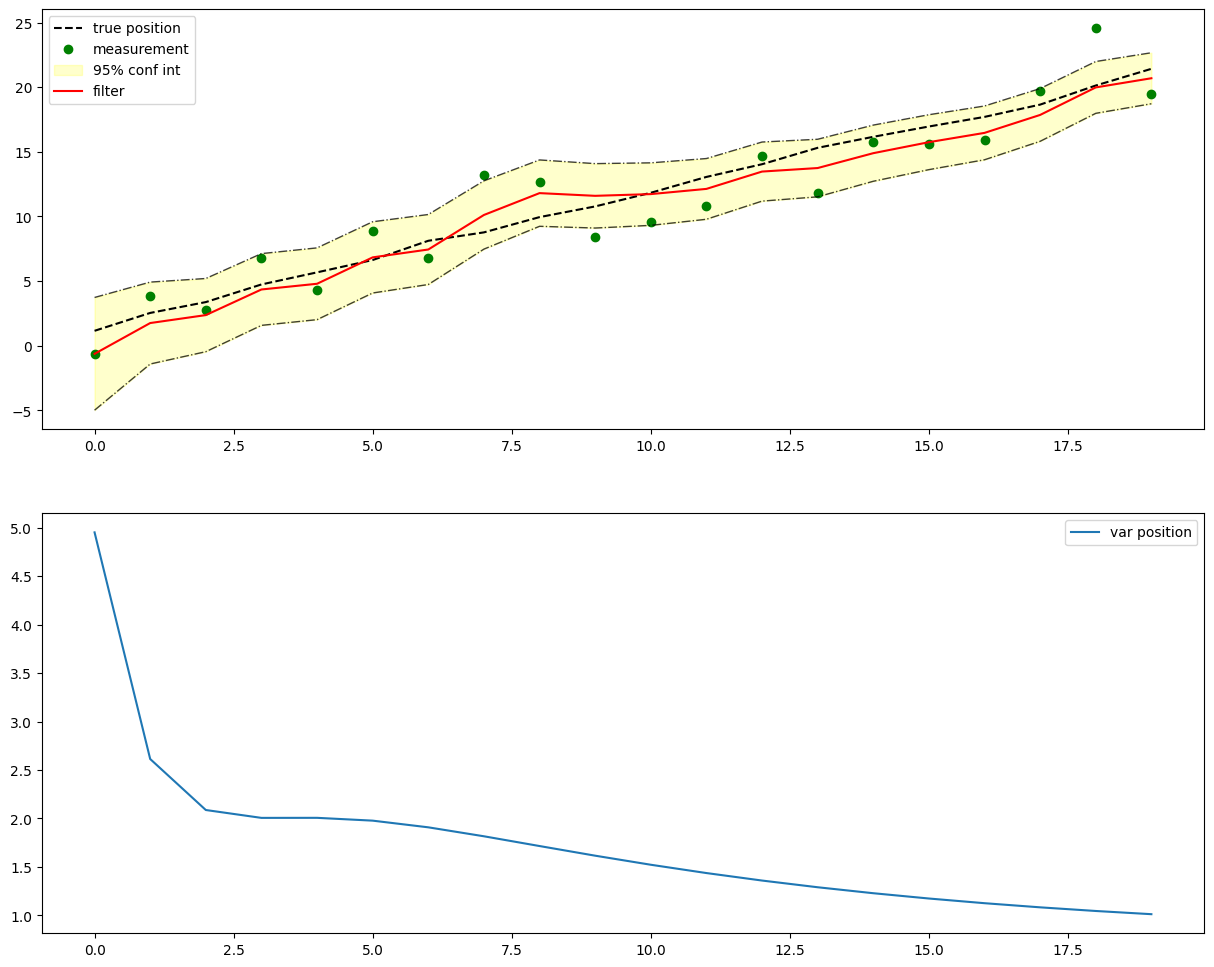

In [38]:
fig, ax = plt.subplots(2, 1, figsize=(15, 12))
ax[0].plot(track, label='true position', color='black', linestyle='dashed')
ax[0].plot(zs, label='measurement', color='green', linewidth=0, marker='o')

_ = get_confidence_interval(xf[0], covf[:,0,0])
ax[0].fill_between(range(0, count), _[0], _[1], alpha=.2, color='yellow', label='95% conf int')
ax[0].plot(_[0], linestyle='dashdot', linewidth=1, alpha=.75, color='black')
ax[0].plot(_[1], linestyle='dashdot', linewidth=1, alpha=.75, color='black')

ax[0].plot(xf[0], label='filter', color='red')
# ax[0].plot(xb[1], label='filter prediction')
ax[0].legend()

ax[1].plot(covf[:, 0, 0], label='var position')
# ax[1].plot(cov1[:, 1, 1], label='var velocity')
ax[1].legend()
;